## Importing Libraries

In [1]:
# Importing Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers

In [2]:
# Constants
batch_size = 128
epochs = 50
latent_dim = 100

images_dir = "../celeba-dataset/img_align_celeba/img_align_celeba"

## Loading Dataset

In [3]:
# Loading dataset
dataset = keras.utils.image_dataset_from_directory(images_dir, 
                                                   labels = None,
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   image_size = (64,64))

dataset = dataset.map(lambda x : x / 255.0)

Found 202599 files belonging to 1 classes.


2021-12-25 09:21:53.789857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 09:21:53.883622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 09:21:53.884497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 09:21:53.887527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2021-12-25 09:21:56.517446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


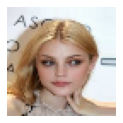

In [4]:
# Showing random image
for x in dataset:
    plt.figure(figsize = (2,2))
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Defining Model

In [5]:
# Defining Discriminator model
discriminator = keras.Sequential(
    [
        Input(shape=(64, 64,3)),
        layers.Conv2D(64, kernel_size = 4, strides = 2, padding = "same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(128, kernel_size = 4, strides = 2, padding = "same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(256, kernel_size = 4, strides = 2, padding = "same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(512, kernel_size = 4, strides = 2, padding = "same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),
        layers.Flatten(),
        layers.Dense(1)
    ],
    name = "Discriminator",
)

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)       

In [6]:
# Defining Generator model
generator = keras.Sequential(
    [
        Input(shape=(latent_dim, )),
        layers.Dense(4 * 4 * 512),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((4, 4, 512)),
        layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = "same", use_bias = False, activation = "tanh")
    ],
    name = "generator"
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097152   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 256)         0 

In [7]:
# Defining GAN model
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_real_loss_metric = keras.metrics.Mean(name="d_real_loss")
        self.d_fake_loss_metric = keras.metrics.Mean(name="d_fake_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
    @property
    def metrics(self):
        return [self.d_real_loss_metric, self.d_fake_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # Training Discriminator on fake image
        generated_images = self.generator(random_latent_vector)
        generated_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as disc_fake_tape:
            predictions = self.discriminator(generated_images)
            d_fake_loss = self.loss_fn(generated_labels, predictions)
        grads = disc_fake_tape.gradient(d_fake_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
        )
        
        # Training Discriminator on real image
        labels = tf.ones((batch_size, 1))
        
        with tf.GradientTape() as disc_real_tape:
            predictions = self.discriminator(real_images)
            d_real_loss = self.loss_fn(labels, predictions)
        grads = disc_real_tape.gradient(d_real_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
        )
        
        # Training Generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gen_tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        # Updating loss
        self.d_real_loss_metric.update_state(d_real_loss)
        self.d_fake_loss_metric.update_state(d_fake_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_real_loss": self.d_real_loss_metric.result(),
            "d_fake_loss": self.d_fake_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
# Class for saving images on epoch end
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img = 10, latent_dim = 100):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{}_{}.png".format(epoch, i))

## Training Model & Saving Weights

In [9]:
# Compiling and training model
gan = GAN(discriminator, generator, latent_dim)
gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.2),
    g_optimizer = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.2),
    loss_fn = keras.losses.BinaryCrossentropy(from_logits = True, label_smoothing = 0.1)
)

gan.fit(dataset, epochs = epochs, callbacks=[GANMonitor(10, latent_dim)])

Epoch 1/50


2021-12-25 09:22:05.917474: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1583/1583 [==============================] - 544s 338ms/step - d_real_loss: 0.6220 - d_fake_loss: 0.6068 - g_loss: 1.0879
Epoch 2/50
1583/1583 [==============================] - 199s 125ms/step - d_real_loss: 0.6138 - d_fake_loss: 0.5767 - g_loss: 1.1301
Epoch 3/50
1583/1583 [==============================] - 205s 129ms/step - d_real_loss: 0.6317 - d_fake_loss: 0.5987 - g_loss: 0.9957
Epoch 4/50
1583/1583 [==============================] - 215s 135ms/step - d_real_loss: 0.6449 - d_fake_loss: 0.6185 - g_loss: 0.9771
Epoch 5/50
1583/1583 [==============================] - 224s 141ms/step - d_real_loss: 0.6272 - d_fake_loss: 0.5917 - g_loss: 0.9873
Epoch 6/50
1583/1583 [==============================] - 201s 126ms/step - d_real_loss: 0.6105 - d_fake_loss: 0.5693 - g_loss: 1.0640
Epoch 7/50
1583/1583 [==============================] - 220s 138ms/step - d_real_loss: 0.6181 - d_fake_loss: 0.5729 - g_loss: 1.1188
Epoch 8/50
1583/1583 [==============================] - 222s 140ms/step - d_real

In [10]:
# Saving weights
gan.save_weights("gan.h5")
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")